# Exploratory Analysis of Amazon-Google Entity Product Matching Data Set

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
# Navigate to current EDA directory as the relative path point
%pwd

'c:\\Users\\seans\\Documents\\neural_entity_matching\\eda'

In [2]:
amz_train = pd.read_csv("../data/amazon_google/Amazon_train.csv",index_col="id")
g_train = pd.read_csv("../data/amazon_google/Google_train.csv",index_col="id")

matches_train = pd.read_csv("../data/amazon_google/AG_perfect_matching_train.csv",index_col = ["idAmazon","idGoogleBase"])
matches_test = pd.read_csv("../data/amazon_google/AG_perfect_matching_test.csv",index_col = ["idAmazon","idGoogleBase"])

In [3]:
amz_train = amz_train.rename(columns = {'title':'title_amzn', "description":"description_amzn","manufacturer":"manufacturer_amzn"} )
g_train = g_train.rename(columns = {'name':'title_g', "description":"description_g","manufacturer":"manufacturer_g"})

Get a distribution of Levenstein edit distance. Idea is that we want to produce data sets with the following characteristics.

* Contains positive matches in the same proportion as the real world data sets.
* Contains examples of positive matches, "difficult" true negatives and easy to spot out easy negatives

In producing this data set we take random samples using a cheap operation on a subset of columns CHOSEN BY THE USER. Sample from positive matches and generate a distribution of edit distances. We can interpet te top 10% of distances as difficuly true positives and the closest 10% as the easy examples then work from there. This is an automatic proceedure which can be made reproducible via the use of a seed


In [4]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [5]:
# Generate a perfect match table
## Join Amazon Products
perfect_matches = pd.merge(amz_train, matches_train, how = 'inner', left_index=  True , right_on = matches_train.index.get_level_values("idAmazon"), suffixes = ("amzn_x","amzn_y"))
perfect_matches = perfect_matches.iloc[:,2:5]
#perfect_matches.columns = perfect_matches.columns.map(lambda x: x + "_amzn")
## Join Google Products
perfect_matches = pd.merge(g_train, perfect_matches, how = 'inner', left_index=  True , right_on = perfect_matches.index.get_level_values("idGoogleBase"), suffixes = ("g_x","g_y"))
perfect_matches = perfect_matches.rename(columns = {'name':'title_g', "description":"description_g","manufacturer":"manufacturer_g"})
## Remove junk columns
perfect_matches.drop(columns = ['key_0', 'Unnamed: 0'],inplace = True)


In [6]:
# Generate Negative Match table
## These rows are not involved in a match AT ALL. Need to reconstruct convincing negative pairs via edit distance
negative_amzn = amz_train[~amz_train.index.isin(perfect_matches.index.get_level_values("idAmazon"))]
negative_g = g_train[~g_train.index.isin(perfect_matches.index.get_level_values("idGoogleBase"))]


In [29]:
SAMPLE_SIZE = 100
true_matches_sample = perfect_matches.sample(n = SAMPLE_SIZE)
negative_amzn_sample = negative_amzn.sample(n = SAMPLE_SIZE)
negative_g_sample = negative_g.sample(n = SAMPLE_SIZE)
negative_matches = pd.concat([negative_amzn_sample.reset_index(), negative_g_sample.reset_index()], axis = 1)
negative_matches_sample = negative_matches.sample(n = SAMPLE_SIZE)



def calculate_edit_distance(x,cols):
    return fuzz.ratio("".join(str(x[cols[0]])), "".join(str(x[cols[1]])))

def generate_distance_samples(n, true_matches, negative_matches, distance_cols, plot = True):
    '''
    Inputs:
        n: Sample Size of true and positive match pairs to take WITHOUT replacement
        true_matches/negative_matches: DataFrame of true/negative match pairs
        distance_cols: column names in true/negative match tables used to calculate edit distance.
                        This is a nested list of length 2. The first nested list contains names of columns
                        to be used within each match table comparison for the first candidate entity. Second
                        list is second candidate entity columns. Columns are concatenated together to form a single
                        edit comparison string. [candidate_entity_1_cols, candidate_entity_2_cols]
                        All column names should reside in both the true_matches and negative_matches tables

    Outputs:
        Tuple (true_matches similarities, negative_matches similarities) 
    '''

    true_matches_sample = true_matches.sample(n = n)
    negative_matches_sample = negative_matches.sample(n = n)
    true_matches_sample["similarity"]= true_matches_sample.apply(axis = 1, func = calculate_edit_distance, cols = distance_cols)
    negative_matches_sample["similarity"]= negative_matches_sample.apply(axis = 1, func = calculate_edit_distance, cols = distance_cols)

    if plot:
        sns.distplot(true_matches_sample.similarity)
        sns.distplot(negative_matches_sample.similarity, color = "red")

    return (true_matches_sample.similarity, negative_matches_sample.similarity)









# true_matches_sample["similarity"]= true_matches_sample.apply(axis = 1, func = calculate_edit_distance, cols = ["title_g","title_amzn"])
# negative_matches_sample["similarity"]= negative_matches_sample.apply(axis = 1, func = calculate_edit_distance, cols = ["title_g","title_amzn"])
# sns.distplot(true_matches_sample.similarity)
# sns.distplot(negative_matches_sample.similarity, color = "red")



Help on function generate_distance_samples in module __main__:

generate_distance_samples(n, true_matches, negative_matches, distance_cols, plot=True)
    Inputs:
        n: Sample Size of true and positive match pairs to take WITHOUT replacement
        true_matches/negative_matches: DataFrame of true/negative match pairs
        distance_cols: column names in true/negative match tables used to calculate edit distance.
                        This is a nested list of length 2. The first nested list contains names of columns
                        to be used within each match table comparison for the first candidate entity. Second
                        list is second candidate entity columns. Columns are concatenated together to form a single
                        edit comparison string. [candidate_entity_1_cols, candidate_entity_2_cols]
                        All column names should reside in both the true_matches and negative_matches tables
    
    Outputs:
        Tuple (true

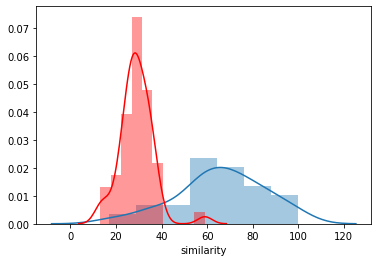

In [30]:
generate_distance_samples(50, perfect_matches ,negative_matches, ["title_g","title_amzn"])
help(generate_distance_samples)


(idAmazon    idGoogleBase                                                  
 b0009yx9bo  http://www.google.com/base/feeds/snippets/18395787464051623418    47
 b000bwzxk4  http://www.google.com/base/feeds/snippets/8498979351589060419     34
 b000067fk7  http://www.google.com/base/feeds/snippets/3785999369106891548     43
 b0000azvvs  http://www.google.com/base/feeds/snippets/5310740648374994867     24
 b0009dwkwo  http://www.google.com/base/feeds/snippets/9753054521720614066     27
 b000nlwxii  http://www.google.com/base/feeds/snippets/18046511712294457433     2
 b000k757w4  http://www.google.com/base/feeds/snippets/17265475148454123541    21
 b000dinb4g  http://www.google.com/base/feeds/snippets/13769671790180310327     5
 b000pg8kxs  http://www.google.com/base/feeds/snippets/13312621869477195220    26
 b0009nr9mu  http://www.google.com/base/feeds/snippets/16755727468265308879    45
 b000ogsyjy  http://www.google.com/base/feeds/snippets/16579315096492817894     3
 b0000y7wck  http://ww

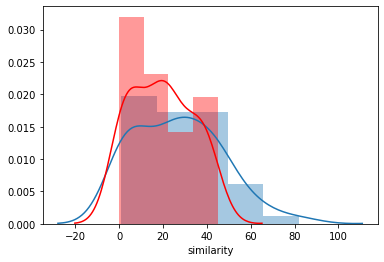

In [26]:
generate_distance_samples(50, perfect_matches ,negative_matches, ["description_g","description_amzn"])


(idAmazon    idGoogleBase                                                  
 b000in6trc  http://www.google.com/base/feeds/snippets/6874875179525744781      11
 b000ndibbo  http://www.google.com/base/feeds/snippets/16934204320953872944     25
 b0007sxglk  http://www.google.com/base/feeds/snippets/17762641182538089473     22
 b0006g31i6  http://www.google.com/base/feeds/snippets/18405362244680246986     10
 b00004tkvy  http://www.google.com/base/feeds/snippets/18441110047404795849     10
 b000cp4ja0  http://www.google.com/base/feeds/snippets/3040037286169376262      22
 b000e3fn4g  http://www.google.com/base/feeds/snippets/9584209186514584056      24
 b00006hvvo  http://www.google.com/base/feeds/snippets/9687887699930800156      19
 b000hcz8gc  http://www.google.com/base/feeds/snippets/9807438286656285076       0
 b0001wn1ee  http://www.google.com/base/feeds/snippets/12776057589362570320      0
 b000h22rbg  http://www.google.com/base/feeds/snippets/10500380486679990055     22
 b000pg8kxs

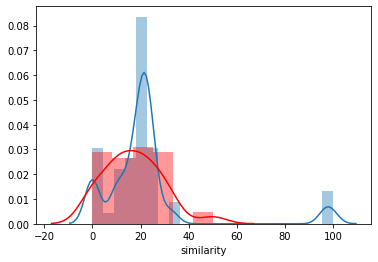

In [27]:
generate_distance_samples(50, perfect_matches ,negative_matches, ["manufacturer_g","manufacturer_amzn"])

In matching products, do the PRICES match exactly?

(idAmazon    idGoogleBase                                                  
 b000h16p9w  http://www.google.com/base/feeds/snippets/12831181740691949409    77
 b0002w37x8  http://www.google.com/base/feeds/snippets/18444171148464728826    82
 b000b6vlh4  http://www.google.com/base/feeds/snippets/10993073455692001778    76
 b0007ly3zu  http://www.google.com/base/feeds/snippets/16699804671191247885    79
 b000hbxjxc  http://www.google.com/base/feeds/snippets/11409582066977374017    81
 b000hed3fi  http://www.google.com/base/feeds/snippets/5655410586169835557     75
 b0006oei8u  http://www.google.com/base/feeds/snippets/18409822956112890125    72
 b000ov404w  http://www.google.com/base/feeds/snippets/18304611545439824631    80
 b000exs456  http://www.google.com/base/feeds/snippets/7954126691882273345     81
 b000gr1ceu  http://www.google.com/base/feeds/snippets/4703701453618359906     75
 b000bi641a  http://www.google.com/base/feeds/snippets/8050920942672245174     85
 b000hbxjxc  http://ww

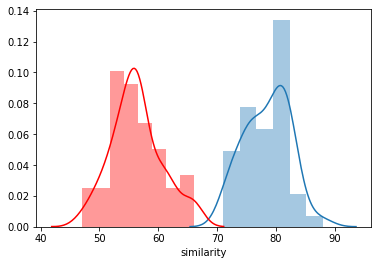

In [28]:
generate_distance_samples(50, perfect_matches ,negative_matches, [["title_g","description_g"],["title_amzn","description_amzn"]])

Now that a similarity function is written. User specifies how the rough specification is calculated. Define a train-validation split function in order to create a sensible sampling of the data using the sampling distancing function. An option, shallow learner to split difficulty into easy, medium and difficult for all samples

* Given a SINGLE matching pair table and Q other tables, merge and output positive matches and negative matches
* Generate Edit distance distributions from positive and negative match tables and from there categorise examples into easy, medium hard
* Generate train-valid data sets incorporating user specified proportions of easy,medium and hard positive & negative matches

Side question, do prices match perfectly in matched pairs? Look below. Answer is no

In [41]:
print(amz_train.loc[perfect_matches.index.get_level_values(0)[0:3]]["price"])
print(g_train.loc[perfect_matches.index.get_level_values(1)[0:3]]["price"])

idAmazon
b00004tkvy      0.00
b000g80lqo    599.99
b0006se5bq     99.99
Name: price, dtype: float64
idGoogleBase
http://www.google.com/base/feeds/snippets/18441110047404795849      9.95
http://www.google.com/base/feeds/snippets/18441188461196475272    590.35
http://www.google.com/base/feeds/snippets/18428750969726461849      82.5
Name: price, dtype: object
